### FM

In [1]:
import numpy as np
import mxnet as mx
from   mxnet import nd
from   mxnet import gluon

def triu_mask(input_size, F=nd):
    """Generate a square matrix with its upper trianguler elements being 1 and others 0.
    """
    mask = F.expand_dims(F.arange(input_size), axis=0)
    return (F.transpose(mask) < mask) * 1.0

def VtoQ(V, F=nd):
    """Calculate interaction strength by inner product of feature vectors.
    """
    input_size = V.shape[1]
    Q = F.dot(F.transpose(V), V) # (d,d)
    return Q * triu_mask(input_size, F)

class QuadraticLayer(gluon.nn.HybridBlock):
    """A neural network layer which applies quadratic function on the input.

    This class defines train() method for easy use.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def init_params(self, initializer=mx.init.Normal()):
        """Initialize all parameters

        Args:
            initializer(mx.init.Initializer):
                MXNet initializer object. [Default=mxnet.init.Normal()]
        """
        self.initialize(initializer, force_reinit=True)

    def train(self, x, y, num_epoch=100, learning_rate=1.0e-2):
        """Training of the regression model using Adam optimizer.
        """
        x, y = nd.array(x), nd.array(y)
        batchsize = x.shape[0]
        if None == self.trainer:
            self.trainer = gluon.Trainer(self.collect_params(), "adam", {"learning_rate": learning_rate})
        else:
            self.trainer.set_learning_rate(learning_rate)
        for epoch in range(num_epoch):
            with mx.autograd.record():
                output = self(x)
                loss = nd.mean((y - output)**2)
            loss.backward()
            self.trainer.step(batchsize, ignore_stale_grad=True)

    def get_bhQ(self):
        raise NotImplementedError()

class FactorizationMachine(QuadraticLayer):
    """Factorization Machine as a neural network layer.

    Args:
        input_size (int):
            The dimension of input value.
        factorization_size (int (<=input_size)):
            The rank of decomposition of interaction terms.
        act (string, optional):
            Name of activation function applied on FM output: "identity", "sigmoid", or "tanh". (default="identity")
        **kwargs:
    """

    def __init__(self, input_size, factorization_size=8, act="identity", **kwargs):
        super().__init__(**kwargs)
        self.factorization_size = factorization_size
        self.input_size = input_size
        self.trainer = None
        with self.name_scope():
            self.h = self.params.get("h", shape=(input_size,), dtype=np.float32)
            if factorization_size > 0:
                self.V = self.params.get("V", shape=(factorization_size, input_size), dtype=np.float32)
            else:
                self.V = self.params.get("V", shape=(1, input_size), dtype=np.float32) # dummy V
            self.bias = self.params.get("bias", shape=(1,), dtype=np.float32)
        self.act = act

    def hybrid_forward(self, F, x, h, V, bias):
        """Forward propagation of FM.

        Args:
          x: input vector of shape (N, d).
          h: linear coefficient of lenth d.
          V: matrix of shape (k, d).
        """
        if self.factorization_size <= 0:
            return bias + F.dot(x, h)
        Q = VtoQ(V, F) # (d,d)
        Qx = F.FullyConnected(x, weight=Q, bias=None, no_bias=True, num_hidden=self.input_size)
        act = {"identity": F.identity, "sigmoid": F.sigmoid, "tanh": F.tanh}[self.act]
        return act(bias + F.dot(x, h) +  F.sum(x*Qx, axis=1))

    def get_bhQ(self):
        """Returns linear and quadratic coefficients.
        """
        V = nd.zeros(self.V.shape) if self.factorization_size == 0 else self.V.data()
        return self.bias.data().asscalar(), self.h.data().asnumpy(), VtoQ(V, nd).asnumpy()


### BQM

In [2]:
import dimod

from dimod.binary_quadratic_model import BinaryQuadraticModel
from dimod.vartypes import Vartype, as_vartype
from dimod import BQM

from matplotlib import pyplot as plt

plt.style.use('dark_background')


class FactorizationMachineBinaryQuadraticModel(BinaryQuadraticModel):
    """FMBQM: Trainable BQM based on Factorization Machine

    Args:
        input_size (int):
            The dimension of input vector.
        vartype (dimod.vartypes.Vartype):
            The type of input vector.
        act (string, optional):
            Name of activation function applied on FM output: "identity", "sigmoid", or "tanh".
    """

    def __init__(self, input_size, vartype, act="identity", **kwargs):
        # Initialization of BQM
        init_linear = {i: 0.0  for i in range(input_size)}
        init_quadratic  = {}
        init_offset = 0.0
        super().__init__(init_linear,  init_quadratic, init_offset, vartype, **kwargs)
        self.fm = FactorizationMachine(input_size, act=act, **kwargs)

    def to_qubo(self):
        return self._fm_to_qubo()

    def to_ising(self):
        return self._fm_to_ising()

    @classmethod
    def from_data(cls, x, y, act="identity", num_epoch=1000, learning_rate=1.0e-2, **kwargs):
        """Create a binary quadratic model by FM regression model trained on the provided data.

        Args:
            x (ndarray, int):
                Input vectors of SPIN/BINARY.
            y (ndarray, float):
                Target values.
            act (string, optional):
                Name of activation function applied on FM output: "identity", "sigmoid", or "tanh".
            num_epoch (int, optional):
                The number of epoch for training FM model.
            learning_rate (int, optional):
                Learning rate for FM's optimizer.
            **kwargs:

        Returns:
            :class:`.FactorizationMachineBinaryQuadraticModel`
        """
        if np.all((x == 0) | (x == 1)):
            vartype = Vartype.BINARY
        elif np.all((x == -1) | (x == 1)):
            vartype = Vartype.SPIN
        else:
            raise ValueError("input data should BINARY or SPIN vectors")

        input_size = x.shape[-1]
        fmbqm = cls(input_size, vartype, act, **kwargs)
        fmbqm.train(x, y, num_epoch, learning_rate, init=True)
        return fmbqm

    def train(self, x, y, num_epoch=1000, learning_rate=1.0e-2, init=False):
        """Train FM regression model on the provided data.

        Args:
            x (ndarray, int):
                Input vectors of SPIN/BINARY.
            y (ndarray, float):
                Target values.
            num_epoch (int, optional):
                The number of epoch for training FM model.
            learning_rate (int, optional):
                Learning rate for FM's optimizer.
            init (bool, optional):
                Initialize or not before training.
        """
        if init:
            self.fm.init_params()
        self._check_vartype(x)
        self.fm.train(x, y, num_epoch, learning_rate)
        if self.vartype == Vartype.SPIN:
            h, J, b = self._fm_to_ising()
            self.offset = b
            for i in range(self.fm.input_size):
                self.linear[i] = h[i]
                for j in range(i+1, self.fm.input_size):
                    self.quadratic[(i,j)] = J.get((i,j), 0)
        elif self.vartype == Vartype.BINARY:
            Q, b = self._fm_to_qubo()
            self.offset = b
            for i in range(self.fm.input_size):
                self.linear[i] = Q[(i,i)]
                for j in range(i+1, self.fm.input_size):
                    self.quadratic[(i,j)] = Q.get((i,j), 0)

    def predict(self, x):
        """Predict target value by trained model.

        Args:
            x (ndarray, int):
                Input vectors of SPIN/BINARY.

        Returns:
            :obj:`numppy.ndarray`: Predicted values.
        """
        self._check_vartype(x)
        x = nd.array(x)
        if len(x.shape) == 1:
            x = nd.expand_dims(x, axis=0)
        return self.fm(x).asnumpy()

    def _check_vartype(self, x):
        if (self.vartype is Vartype.BINARY) and np.all((1 == x) | (0 == x)) or \
           (self.vartype is Vartype.SPIN) and np.all((1 == x) | (-1 == x)):
            return
        raise ValueError("input data should be of type", self.vartype)

    def _fm_to_ising(self, scaling=True):
        """Convert trained model into Ising parameters.

        Args:
            scaling (bool, optional):
                Flag for automatic scaling.

        """
        b, h, J = self.fm.get_bhQ()
        if self.vartype is Vartype.BINARY:
            b = b + np.sum(h)/2 + np.sum(J)/4
            h = (2*h + np.sum(J, axis=0) + np.sum(J, axis=1))/4.0
            J = J/4.0
        if scaling:
            scaling_factor = max(np.max(np.abs(h)), np.max(np.abs(J)))
            b /= scaling_factor
            h /= scaling_factor
            J /= scaling_factor
        return {key: h[key] for key in range(len(h))}, {key: J[key] for key in zip(*J.nonzero())}, b

    def _fm_to_qubo(self, scaling=True):
        """Convert trained model into QUBO parameters.

        Args:
            scaling (bool, optional):
                Flag for automatic scaling.
        """
        b, h, Q = self.fm.get_bhQ()
        if self.vartype is Vartype.SPIN:
            b = b - np.sum(h) + np.sum(Q)
            h = 2 * (h - np.sum(Q, axis=0) - np.sum(Q, axis=1))
            Q = 4 * Q
        Q[np.diag_indices(len(Q))] = h
        if scaling:
            scaling_factor = np.max(np.abs(Q))
            b /= scaling_factor
            Q /= scaling_factor
        # Conversion from full matrix to dict
        Q_dict = {key: Q[key] for key in zip(*Q.nonzero())}
        for i in range(len(Q)):
            Q_dict[(i,i)] = Q[i,i]

        return Q_dict, b

FMBQM = FactorizationMachineBinaryQuadraticModel

### Example

In [23]:
def two_complement(x, scaling=True):
    '''
    Evaluation function for binary array
    of two's complement representation.

    example (when scaling=False):
    [0,0,0,1] => 1
    [0,0,1,0] => 2
    [0,1,0,0] => 4
    [1,0,0,0] => -8
    [1,1,1,1] => -1
    '''
    
    val = 0
    n = len(x)
    
    for i in range(n):
        val += (1 << (n - i - 1)) * x[i] * (1 if (i > 0) else -1)
        
    return val * (2 ** (1 - n) if scaling else 1)

In [24]:
SAMPLE_SIZE = 16
SCALING = False

xs = np.random.randint(2, size=(5, SAMPLE_SIZE))
ys = np.array([two_complement(x, scaling=SCALING) for x in xs])

print("xs:\n", xs)
print("ys:\n", ys)

xs:
 [[1 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1]
 [1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0]
 [0 1 0 1 0 1 1 1 0 0 0 1 1 0 1 0]
 [1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0]]
ys:
 [-14093  -7960  24620  22298 -31716]


In [25]:
model = FMBQM.from_data(xs, ys)

sa_sampler = dimod.samplers.SimulatedAnnealingSampler()

In [44]:
# Train

STEPS_COUNT = 1

for step in range(STEPS_COUNT):
    
    print("step:", step)
    
    results = sa_sampler.sample(model, num_reads=3)
    print("results:", results)
    
    new_samples = results.record['sample']
    print("new_samples:\n", new_samples)
    
    xs = np.r_[xs, new_samples]
    ys = np.r_[ys, [two_complement(sample, scaling=SCALING) for sample in new_samples]]
    
    print("xs:\n", xs.shape)
    print("ys:\n", ys)    
    
    model.train(xs, ys)

step: 0
results:    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15    energy num_oc.
1  1  0  0  0  0  1  1  0  1  1  0  0  1  1  1  1 -2.294197       1
2  1  0  0  0  0  0  1  1  1  1  0  1  0  1  1  0 -1.972461       1
0  1  0  0  0  1  1  1  1  0  0  1  1  1  1  0  1 -1.818399       1
['BINARY', 3 rows, 3 samples, 16 variables]
new_samples:
 [[1 0 0 0 1 1 1 1 0 0 1 1 1 1 0 1]
 [1 0 0 0 0 1 1 0 1 1 0 0 1 1 1 1]
 [1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 0]]
xs:
 (59, 16)
ys:
 [-14093  -7960  24620  22298 -31716 -28955 -16957 -13865 -21539  -4649
 -17155 -14115 -13081 -28691 -24835 -12571 -28947 -22915 -25141 -29855
 -26171 -16917 -13075 -28851 -25227 -24883 -22681 -18125 -30243 -28979
 -28831 -29185 -25139 -16621 -13925 -29578 -29338 -21918 -28036 -24250
 -22314 -28332 -23324 -27394 -20403 -31290 -17708 -25109 -23100 -32515
 -31002 -22043 -26649 -21661 -29725 -29061 -28867 -31025 -31786]


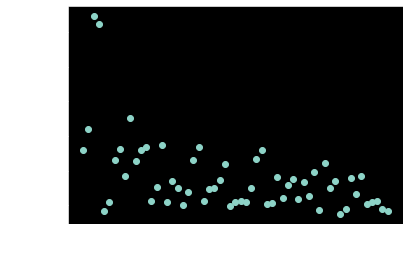

In [45]:
plt.plot(ys, 'o')
plt.xlabel('Sample')
plt.ylabel('Two Complement')
# plt.ylim([-1.0, 1.0])
plt.show()